# Multivariate Time Series Forecasting
# Long Short-Term Memory (LSTM)

Based on Jason Brownlee's tutorial: [Multivariate Time Series Forecasting with LSTMs in Keras](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)

In [1]:
from math import sqrt
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
parse = lambda x: pd.datetime.strptime(x, '%Y %m %d %H')
df = pd.read_csv('pollution.csv', \
                 parse_dates =[['year', 'month', 'day', 'hour']], \
                 skiprows=25, \
                 usecols=[1,2,3,4,5,6,7,8,9,10,11,12], \
                 names = ["year","month","day", "hour","pollution","dew","temp","press", "wnd_dir","wnd_spd","snow", "rain"], \
                 date_parser = parse, \
                index_col=0)

df.index.name = 'date'
# mark all NA values with 0
df['pollution'].fillna(0, inplace=True)

In [3]:
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


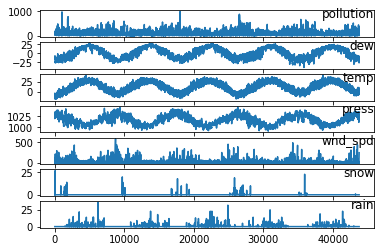

In [4]:
# plots each series as a separate subplot
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [5]:
df.dtypes

pollution    float64
dew            int64
temp         float64
press        float64
wnd_dir       object
wnd_spd      float64
snow           int64
rain           int64
dtype: object

In [6]:
# Encode the categorical columns
# in this case, we have only wnd_dir
# df --> data
from sklearn.preprocessing import LabelEncoder

encs = dict()
data = df.copy()  #.sample(frac=1)
for c in data.columns:
    if data[c].dtype == "object":
        encs[c] = LabelEncoder()
        data[c] = encs[c].fit_transform(data[c])

In [7]:
data.dtypes

pollution    float64
dew            int64
temp         float64
press        float64
wnd_dir        int32
wnd_spd      float64
snow           int64
rain           int64
dtype: object

In [8]:
# ensure all data is float
values = data.values.astype('float32')

In [9]:
# normalize features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [10]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)


In [11]:
# To understand this function, run each code below in a cell
#reframed[['var1(t)', 'var1(t-1)','var1(t-2)','var1(t-3)']]
#pd.DataFrame(scaled).head()
#0,129779

In [12]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(8760, 24) 8760 (8760,)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)


C:\Users\Ricardo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train on 8760 samples, validate on 35037 samples
Epoch 1/50
 - 1s - loss: 0.0551 - val_loss: 0.0624
Epoch 2/50
 - 0s - loss: 0.0259 - val_loss: 0.0340
Epoch 3/50
 - 0s - loss: 0.0212 - val_loss: 0.0227
Epoch 4/50
 - 0s - loss: 0.0207 - val_loss: 0.0215
Epoch 5/50
 - 0s - loss: 0.0205 - val_loss: 0.0200
Epoch 6/50
 - 0s - loss: 0.0201 - val_loss: 0.0195
Epoch 7/50
 - 0s - loss: 0.0197 - val_loss: 0.0186
Epoch 8/50
 - 1s - loss: 0.0192 - val_loss: 0.0185
Epoch 9/50
 - 0s - loss: 0.0185 - val_loss: 0.0178
Epoch 10/50
 - 0s - loss: 0.0184 - val_loss: 0.0176
Epoch 11/50
 - 0s - loss: 0.0175 - val_loss: 0.0173
Epoch 12/50
 - 0s - loss: 0.0170 - val_loss: 0.0181
Epoch 13/50
 - 0s - loss: 0.0167 - val_loss: 0.0176
Epoch 14/50
 - 0s - loss: 0.0161 - val_loss: 0.0182
Epoch 15/50
 - 1s - loss: 0.0157 - val_loss: 0.0183
Epoch 16/50
 - 1s - loss: 0.0153 - val_loss: 0.0177
Epoch 17/50
 - 1s - loss: 0.0150 - val_loss: 0.0176
Epoch 18/50
 - 1s - loss: 0.0148 - val_loss: 0.0172
Epoch 19/50
 - 1s - loss

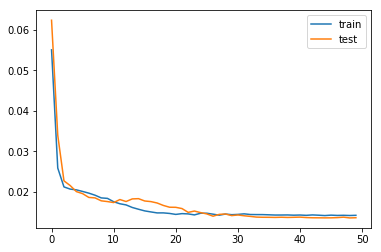

In [14]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [15]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.464


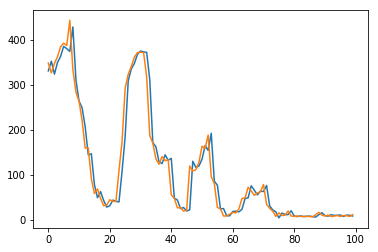

In [16]:
# The predictions look like persistence value(t) = value(t-1)
plt.plot(inv_yhat[-100:])
plt.plot(inv_y[-100:])
plt.show()